In [ ]:
# #Mount the drive
# from google.colab import drive
# import os
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Replace 'your_folder_name' with the actual name of your folder
# folder_path = '/content/drive/MyDrive/Research Project/DiffusionModels_DDPM_DDIM'

# # Check if the folder exists
# if os.path.exists(folder_path):
#   print(f"Folder '{folder_path}' mounted successfully!")
# else:
#   print(f"Folder '{folder_path}' not found. Please check the path.")

# # Now you can access files within the mounted folder
# # For example, to list files in the folder:
# print(len(os.listdir(folder_path)))

Folder '/content/drive/MyDrive/Research Project/DiffusionModels_DDPM_DDIM' mounted successfully!
47


In [ ]:
# Mount the drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Path to your project folder
folder_path = '/content/drive/MyDrive/Research Project/DiffusionModels_DDPM_DDIM'

# Check if the folder exists
if os.path.exists(folder_path):
    print(f"Folder '{folder_path}' mounted successfully!")
    os.chdir(folder_path)  # <-- This is the missing part!
    print("✅ Now working inside:", os.getcwd())
    print("📂 Files here:", os.listdir())
else:
    print(f"Folder '{folder_path}' not found. Please check the path.")

Mounted at /content/drive
Folder '/content/drive/MyDrive/Research Project/DiffusionModels_DDPM_DDIM' mounted successfully!
✅ Now working inside: /content/drive/MyDrive/Research Project/DiffusionModels_DDPM_DDIM
📂 Files here: ['.git', '__pycache__', 'train', 'Sampling_sprites.ipynb', 'train.py', 'Sampling_backbone.ipynb', 'train_attn.py', 'train_hddn.py', 'spatial_helper.py', 'unet_attention.py', 'unet_test.ipynb', 'diffusion_utils (2).py', 'diffusion_utils (1).py', 'diffusion_utils.py', 'Sampling.ipynb', 'L4_FastSampling.ipynb', 'output_image.jpg', 'diffusion_01_score.ipynb', 'helper_plot.py', 'train_context.py', 'train_metadata.csv', 'train_labels.csv', 'gitignore', 'README.md', 'GenerateLabels.ipynb', 'Sampling_attn.ipynb', 'Sampling_attn_M.ipynb', 'GenerateLabels_M.ipynb', 'wind_label_3D128X128.npy', 'wind_3D128X128.npy', 'resnet_helper.py', 'Sampling-1.ipynb', 'GenerateLabels-1.ipynb', 'Sampling-2.ipynb', 'GenerateLabels-2.ipynb', 'GenerateLabels-with-train-val-sets.ipynb', 'Genera

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from torch.utils.data import Dataset
#from diffusion_utils import *

### Copied the diffusion block code here

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

def get_backbone(name, pretrained=True):

    """ Loading backbone, defining names for skip-connections and encoder output. """

    # TODO: More backbones
     # loading backbone model
    if name == 'resnet18':
        backbone = models.resnet18(pretrained=pretrained)
    elif name == 'resnet34':
        backbone = models.resnet34(pretrained=pretrained)
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))
    if name.startswith('resnet'):
        feature_names = [None, 'relu', 'layer1', 'layer2', 'layer3']
        backbone_output = 'layer4'
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    return backbone, feature_names, backbone_output

In [ ]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//32, self.h//32), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)

        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)

        out = self.out(torch.cat((up3, x), 1))
        return out

In [ ]:
# hyperparameters

# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 256 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 128
save_dir = 'weights/'

# training hyperparameters
batch_size = 32
n_epoch = 100
lrate=1e-3

In [ ]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [ ]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
#nn_model =SimpleCNN().to(device)

In [ ]:
# import os

# # Print the current working directory
# print("Current working directory:", os.getcwd())

# # Print the folder_path value
# print("folder_path value:", folder_path)

# # Check if the directory exists
# print("Directory exists:", os.path.exists(folder_path))

# # List files in the directory if it exists
# if os.path.exists(folder_path):
#     print("Files in directory:", os.listdir(folder_path))

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Load real datasets
X_train = np.load('wind_train_3D16X16.npy')
y_train = np.load('wind_label_train_3D16X16.npy')
X_val = np.load('wind_val_3D16X16.npy')
y_val = np.load('wind_label_val_3D16X16.npy')

# Convert numpy arrays to PyTorch tensors and PERMUTE properly
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 3, 16, 16)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 5)  # output 5 values (regression)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, optimizer
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')




Epoch [1/20], Train Loss: 1.4919, Val Loss: 0.1511
Epoch [2/20], Train Loss: 0.1417, Val Loss: 0.1367
Epoch [3/20], Train Loss: 0.1322, Val Loss: 0.1280
Epoch [4/20], Train Loss: 0.1241, Val Loss: 0.1229
Epoch [5/20], Train Loss: 0.1185, Val Loss: 0.1181
Epoch [6/20], Train Loss: 0.1124, Val Loss: 0.1200
Epoch [7/20], Train Loss: 0.1095, Val Loss: 0.1087
Epoch [8/20], Train Loss: 0.1059, Val Loss: 0.1052
Epoch [9/20], Train Loss: 0.1004, Val Loss: 0.1204
Epoch [10/20], Train Loss: 0.1013, Val Loss: 0.1002
Epoch [11/20], Train Loss: 0.0973, Val Loss: 0.1055
Epoch [12/20], Train Loss: 0.0980, Val Loss: 0.1037
Epoch [13/20], Train Loss: 0.0942, Val Loss: 0.1001
Epoch [14/20], Train Loss: 0.0938, Val Loss: 0.0965
Epoch [15/20], Train Loss: 0.0927, Val Loss: 0.1065
Epoch [16/20], Train Loss: 0.0909, Val Loss: 0.0981
Epoch [17/20], Train Loss: 0.0914, Val Loss: 0.0948
Epoch [18/20], Train Loss: 0.0900, Val Loss: 0.0990
Epoch [19/20], Train Loss: 0.0887, Val Loss: 0.0973
Epoch [20/20], Train 

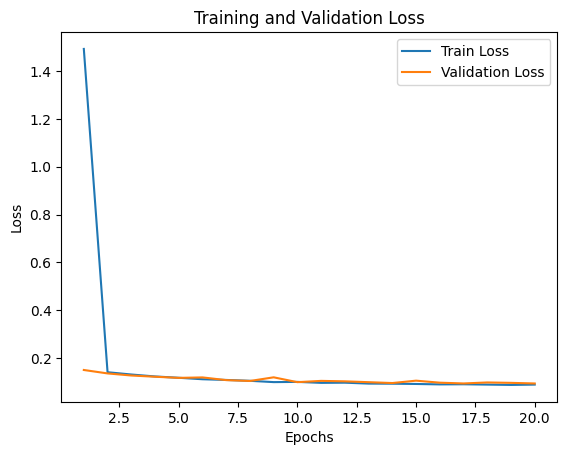

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
train_image_path = os.path.join(folder_path, "wind_3D16X16.npy")                # changing the file "wind_3D128X128.npy" to "wind_3D16X16.npy"
train_label_path = os.path.join(folder_path, "wind_label_3D16X16.npy")                # changing the file "wind_label_3D128X128.npy" to "wind_label_3D16X16.npy"
dataset = CustomDataset(train_image_path, train_label_path, transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (4934, 16, 16, 3)
labels shape: (4934, 5)


In [ ]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [ ]:
# training without context code

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()

        x = x.float().to(device)


        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        #pred_noise = nn_model(x_pert)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|██████████| 155/155 [00:12<00:00, 12.31it/s]


saved model at weights/model_0.pth
epoch 1


100%|██████████| 155/155 [00:11<00:00, 13.98it/s]


epoch 2


100%|██████████| 155/155 [00:11<00:00, 13.89it/s]


epoch 3


100%|██████████| 155/155 [00:11<00:00, 13.69it/s]


epoch 4


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


saved model at weights/model_4.pth
epoch 5


100%|██████████| 155/155 [00:11<00:00, 13.33it/s]


epoch 6


100%|██████████| 155/155 [00:11<00:00, 13.26it/s]


epoch 7


100%|██████████| 155/155 [00:11<00:00, 13.40it/s]


epoch 8


100%|██████████| 155/155 [00:11<00:00, 13.55it/s]


saved model at weights/model_8.pth
epoch 9


100%|██████████| 155/155 [00:11<00:00, 13.61it/s]


epoch 10


100%|██████████| 155/155 [00:11<00:00, 13.65it/s]


epoch 11


100%|██████████| 155/155 [00:11<00:00, 13.59it/s]


epoch 12


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


saved model at weights/model_12.pth
epoch 13


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 14


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


epoch 15


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 16


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


saved model at weights/model_16.pth
epoch 17


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


epoch 18


100%|██████████| 155/155 [00:11<00:00, 13.55it/s]


epoch 19


100%|██████████| 155/155 [00:11<00:00, 13.56it/s]


epoch 20


100%|██████████| 155/155 [00:11<00:00, 13.55it/s]


saved model at weights/model_20.pth
epoch 21


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 22


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


epoch 23


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 24


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


saved model at weights/model_24.pth
epoch 25


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 26


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 27


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 28


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


saved model at weights/model_28.pth
epoch 29


100%|██████████| 155/155 [00:11<00:00, 13.43it/s]


epoch 30


100%|██████████| 155/155 [00:11<00:00, 13.45it/s]


epoch 31


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


epoch 32


100%|██████████| 155/155 [00:11<00:00, 13.43it/s]


saved model at weights/model_32.pth
epoch 33


100%|██████████| 155/155 [00:11<00:00, 13.45it/s]


epoch 34


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


epoch 35


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


epoch 36


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


saved model at weights/model_36.pth
epoch 37


100%|██████████| 155/155 [00:11<00:00, 13.41it/s]


epoch 38


100%|██████████| 155/155 [00:11<00:00, 13.29it/s]


epoch 39


100%|██████████| 155/155 [00:11<00:00, 13.44it/s]


epoch 40


100%|██████████| 155/155 [00:11<00:00, 13.45it/s]


saved model at weights/model_40.pth
epoch 41


100%|██████████| 155/155 [00:11<00:00, 13.30it/s]


epoch 42


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 43


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 44


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


saved model at weights/model_44.pth
epoch 45


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


epoch 46


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 47


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


epoch 48


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


saved model at weights/model_48.pth
epoch 49


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 50


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


epoch 51


100%|██████████| 155/155 [00:11<00:00, 13.54it/s]


epoch 52


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


saved model at weights/model_52.pth
epoch 53


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 54


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


epoch 55


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


epoch 56


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


saved model at weights/model_56.pth
epoch 57


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 58


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 59


100%|██████████| 155/155 [00:11<00:00, 13.53it/s]


epoch 60


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


saved model at weights/model_60.pth
epoch 61


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 62


100%|██████████| 155/155 [00:11<00:00, 13.55it/s]


epoch 63


100%|██████████| 155/155 [00:11<00:00, 13.54it/s]


epoch 64


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


saved model at weights/model_64.pth
epoch 65


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 66


100%|██████████| 155/155 [00:11<00:00, 13.45it/s]


epoch 67


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


epoch 68


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


saved model at weights/model_68.pth
epoch 69


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 70


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 71


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


epoch 72


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


saved model at weights/model_72.pth
epoch 73


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 74


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 75


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 76


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


saved model at weights/model_76.pth
epoch 77


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


epoch 78


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 79


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 80


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


saved model at weights/model_80.pth
epoch 81


100%|██████████| 155/155 [00:11<00:00, 13.42it/s]


epoch 82


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


epoch 83


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


epoch 84


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


saved model at weights/model_84.pth
epoch 85


100%|██████████| 155/155 [00:11<00:00, 13.48it/s]


epoch 86


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


epoch 87


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


epoch 88


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


saved model at weights/model_88.pth
epoch 89


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


epoch 90


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 91


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


epoch 92


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


saved model at weights/model_92.pth
epoch 93


100%|██████████| 155/155 [00:11<00:00, 13.49it/s]


epoch 94


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


epoch 95


100%|██████████| 155/155 [00:11<00:00, 13.52it/s]


epoch 96


100%|██████████| 155/155 [00:11<00:00, 13.50it/s]


saved model at weights/model_96.pth
epoch 97


100%|██████████| 155/155 [00:11<00:00, 13.47it/s]


epoch 98


100%|██████████| 155/155 [00:11<00:00, 13.51it/s]


epoch 99


100%|██████████| 155/155 [00:11<00:00, 13.46it/s]


saved model at weights/model_99.pth


In [ ]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [ ]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0
        #print(samples.shape, t.shape)
        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

### View Epoch 0

In [ ]:
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow((store[i,(row*ncols)+col])))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani


In [ ]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_96.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


In [ ]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(16)
animation_ddpm = plot_sample(intermediate_ddpm,16,4,save_dir, "ani_run", None, save=True)
HTML(animation_ddpm.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [ ]:
# sample quickly using DDIM
@torch.no_grad()
def sample_ddim(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [ ]:
# visualize samples
plt.clf()
samples, intermediate = sample_ddim(16, n=25)
animation_ddim = plot_sample(intermediate,16,4,save_dir, "ani_run", "ddim", save=True)
HTML(animation_ddim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# import pandas as pd

# train_df = pd.read_csv("train_split.csv")
# val_df = pd.read_csv("val_split.csv")

# print("Train columns:", train_df.columns)
# print("Val columns:", val_df.columns)